In [40]:
### https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [41]:
words = open('names.txt', 'r').read().splitlines()

In [42]:
len(words)
#words = words[:5]


32033

In [43]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s,i in stoi.items()}

In [44]:
# Building dataset
block_size = 3 # context length: how many characters do we take to
X = []
Y = []

for w in words[0:5]:
  #print(w)
  context = [0] * block_size

  for c in w + '.':
    yindex = stoi[c]
    X.append(context)
    Y.append(yindex)
    #print(''.join(itos[i] for i in context), '--->', c)
    context = context[1:] + [yindex]

X = torch.tensor(X)
Y = torch.tensor(Y)



In [45]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [46]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [47]:
C = torch.randn((27,2)) # 27 different characters # 2 dimensinal space C= lookup table
# C is embedding table

In [48]:
# Embed a single integer 5 using lookup table C
print(C[5])

# is equal to
#F.one_hot(torch.tensor(5), num_classes=27).float() @ C

# Embedding multiple numbers
#C[torch.tensor([5,6,7])]

C[X]
C[X].shape # original input shape * 2 X.shape = 32*3

tensor([-0.5924,  1.4288])


torch.Size([32, 3, 2])

In [49]:
X[13][2]

tensor(1)

In [50]:
C[X][13][2]

tensor([-1.0717, -0.9892])

In [51]:
C[1] # X[13][2]

tensor([-1.0717, -0.9892])

In [52]:
emb = C[X] # X.shape = 32*3 C[X].shape = 32*3*2
emb.shape

torch.Size([32, 3, 2])

In [53]:
W1 = torch.randn((6,100)) # 3 characters input in layer one each represented by 2 dimensions. so 3*2=6 weights.
# 2nd parameter = no of neurons in next layer
b1 = torch.randn(100)


In [54]:
# We want to calculate - emb @ W + b1
# Flatten embedding - 3 inputs each of dimenstion 2 -> concatenate these. Concatenation will lead to 32 * 6
# emb[:, 0, :]
# emb[:, 1, :]
# emb[:, 2, :]

#torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape
#torch.cat(torch.unbind(emb, 1), 1).shape

# emb.view(32,6)

#h = emb.view(emb.shape[0], 6) @ W1 + b1
# h.shape # 32 inputs or examples extracted from 5 words and 100 neurons
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
h

# broadcasting is happening in + b1
# 32 * 100 +
#    * 100

tensor([[ 0.7840, -0.9993, -0.9463,  ...,  0.9925,  0.6852, -0.9338],
        [-0.4813, -0.9941,  0.8522,  ...,  0.3598,  0.9769, -0.4945],
        [ 0.8636, -0.9637,  0.9305,  ...,  0.9941, -0.7272,  0.9496],
        ...,
        [-0.8956, -0.9235,  0.2241,  ..., -0.8929,  0.5962,  0.9997],
        [ 0.6689, -0.9868, -0.9181,  ...,  0.5311,  0.0264,  0.8418],
        [-0.9900, -0.9929, -0.9441,  ...,  0.4097,  0.9841, -0.9990]])

In [55]:
W2 = torch.randn((100,27))  # 27 characters - outputs
b2 = torch.randn(27)

#print(h.shape)

logits = h @ W2 + b2
logits.shape

counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape # 32 * 27
prob[0].sum()

tensor(1.0000)

In [56]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [57]:
loss = - prob[torch.arange(32), Y].log().mean()
loss

tensor(17.2609)

In [58]:
##### Main Implementation ######


In [59]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [60]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [61]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [62]:
for p in parameters:
  p.requires_grad = True

In [63]:
lre = torch.linspace(-3, 0, 1000) # learning rate - 10 pow -3 = 0.1 to 10 pow 0 = 1 # 1000 values between these
lrs = 10**lre

In [64]:
lri = []
lossi = []
stepi = []

In [66]:
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  #forward pass
  emb = C[Xtr[ix]]  # [32,3,10]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # [32 * 27]
  loss = F.cross_entropy(logits, Ytr[ix]) # count by exp, normalize, log, mean, -ve
  #print(loss.item())

  #backward pass
  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01 # learning rate
  for p in parameters:
    p.data = p.data - lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())


2.054163932800293


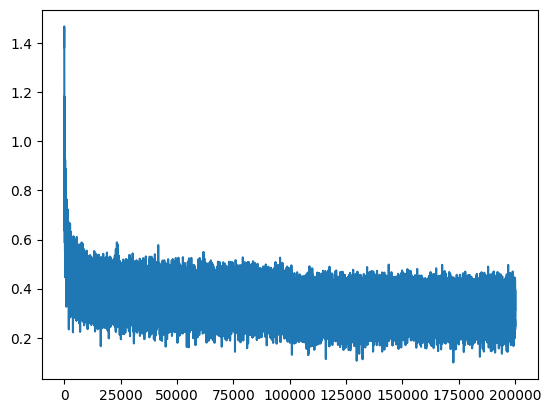

In [67]:
plt.plot(stepi, lossi)

In [68]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1223, grad_fn=<NllLossBackward0>)

In [69]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1626, grad_fn=<NllLossBackward0>)

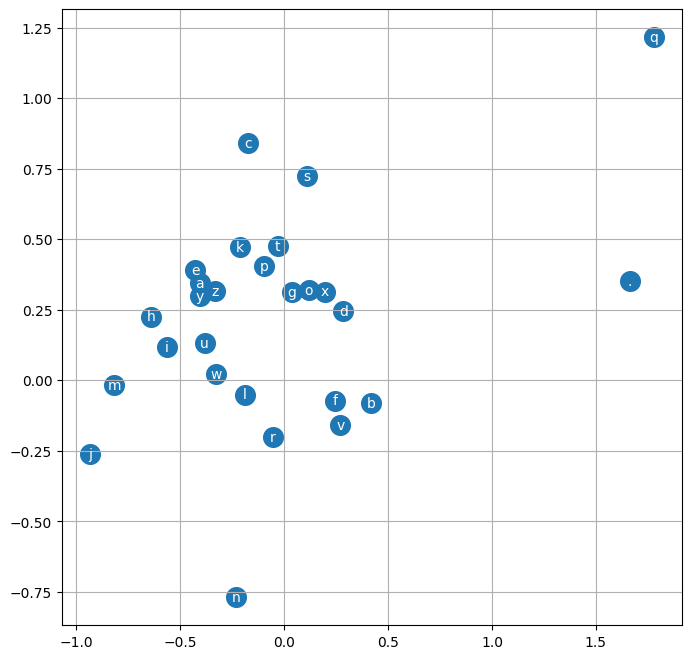

In [70]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [72]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d) # [1,3,10]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1) # exp, normalization
      # returns a tensor where each row contains num_samples indices sampled
      # from the multinomial probability distribution of the corresponding row in the input tensor.
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
mad.
ryah.
rethrus.
jernee.
azeredielin.
shi.
jenrekeiseananareelynn.
hokelin.
shubergahimiel.
kindreelle.
xnie.
cay.
brence.
ryyah.
fael.
yuma.
myskayleehal.
